# Source contributions

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import seaborn as sns; sns.set()
import pandas as pd
from datetime import date

%matplotlib notebook

###### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax-imin
jsize = jmax-jmin

# model result set:
results_folder1 = '/data/brogalla/run_storage/Mn-set4-202004/'

colors = ['#ccb598', '#448d90', '#739f78', '#CC8741', '#cee7fd', '#b9c1c7']

In [4]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, \
         2017, 2018, 2019]

###### Load files:

In [16]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
# land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
# mesh      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12-EXH006_y2015m01d05_gridT.nc')
# lons      = np.array(mesh.variables['nav_lon'])
# lats      = np.array(mesh.variables['nav_lat'])

e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t      = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
# e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t
volume_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), volume)

In [5]:
totals_exp1, CB_totals_exp1, CAA_totals_exp1, wCAA_totals_exp1, eCAA_totals_exp1 = \
                pickle.load(open('calculations/exp1-total_component_contributions-20201018.pickle','rb')) 
totals_exp2, CB_totals_exp2, CAA_totals_exp2, wCAA_totals_exp2, eCAA_totals_exp2 = \
                pickle.load(open('calculations/exp2-total_component_contributions-20201018.pickle','rb')) 
averages_exp1, CB_averages_exp1, CAA_averages_exp1, wCAA_averages_exp1, eCAA_averages_exp1 = \
                pickle.load(open('calculations/exp1-averages_component_contributions-20201018.pickle','rb')) 
averages_exp2, CB_averages_exp2, CAA_averages_exp2, wCAA_averages_exp2, eCAA_averages_exp2 = \
                pickle.load(open('calculations/exp2-averages_component_contributions-20201018.pickle','rb')) 

In [6]:
# sea_ice = '/ocean/brogalla/GEOTRACES/data/Sea_Ice_Index_Rates_of_Change_G02135_v3.0.csv'

# regions are defined in: 
# https://nsidc.org/sites/nsidc.org/files/files/data/noaa/g02135/Sea-Ice-Analysis-Spreadsheets-Overview.pdf
# This file is for the Beaufort Sea region, i.e. Canada Basin
sea_ice_CB = '/ocean/brogalla/GEOTRACES/data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.csv'
sea_ice_CA = '/ocean/brogalla/GEOTRACES/data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0-central-arctic.csv'

si_CB = pd.read_csv(sea_ice_CB)
si_CA = pd.read_csv(sea_ice_CA)

In [12]:
# Find indices to separate out Canada Basin:
x_ind = np.arange(1620, 2100, 1)
y_ind = (-7/8)*x_ind + 1517 + 700

CB_indx = []
CB_indy = []
for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2180,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)

# Separate Canada Basin:
mask_ini_CB  = np.zeros((isize,jsize))
for i, j in zip(CB_indx, CB_indy):
    mask_ini_CB[int(i-imin),int(j-jmin)]  = 1
    
mask_ini_CB[150:-1 ,-8:-1] = 1

mask_CB_yr    = np.tile(mask_ini_CB  , (12,1,1))
mask_CB_depth = np.tile(mask_CB_yr  , (50,1,1,1))
mask_CB_depth = mask_CB_depth.reshape(12,50,700,640)

##### Functions:

In [17]:
def read_yearly_mn(years, results_folder=results_folder1):
    
    yearly_mn = []
    for year in years:
        Mn_model1  = nc.Dataset(results_folder+'ref-'+str(year)+'/ANHA12_EXH006_'+str(year)+'_monthly.nc')
        Mn_dis1    = np.array(Mn_model1.variables['dissolmn'])[:,0,:,:,:]
        
        Mn_CB      = np.ma.masked_where(mask_CB_depth==0, Mn_dis1)
        
        # Polar mixed layer:
        Mn_yearly  = np.ma.sum(Mn_CB[:,0:17,:,:], axis=0)
        Mn_content = np.ma.sum(Mn_yearly*volume_masked[0:17,:,:]*1e3, axis=(0,1,2))
        yearly_mn.append(Mn_content) # moles
        
    return np.array(yearly_mn)

### Figures

Year-to-year variation in contribution

In [8]:
observ_data_CB = np.array(si_CB)
observ_data_CA = np.array(si_CA)

observ_years_CB     = observ_data_CB[:,0].astype('float')
observ_years_CA     = observ_data_CA[:,0].astype('float')
monthly_ice_area_CB = observ_data_CB[:,1:].astype('float')
monthly_ice_area_CA = observ_data_CA[:,1:].astype('float')

ice_areas_CB = monthly_ice_area_CB.flatten()
ice_areas_CA = monthly_ice_area_CA.flatten()
ice_areas_diff_CB = [ice_areas_CB[i+1] - ice_areas_CB[i] for i in range(0,len(ice_areas_CB)-1)]
ice_areas_diff_CA = [ice_areas_CA[i+1] - ice_areas_CA[i] for i in range(0,len(ice_areas_CA)-1)]

ice_areas_diff_CB = np.append(np.nan, ice_areas_diff_CB)
ice_areas_diff_CA = np.append(np.nan, ice_areas_diff_CA)

monthly_area_change_CB = ice_areas_diff_CB.reshape([41,12])
monthly_area_change_CA = ice_areas_diff_CA.reshape([41,12])
    
monthly_area_melt_CB = np.copy(monthly_area_change_CB)
monthly_area_melt_CA = np.copy(monthly_area_change_CA)
monthly_area_melt_CB[monthly_area_change_CB > 0] = 0 
monthly_area_melt_CA[monthly_area_change_CA > 0] = 0 

# Calculate the sum of all the melt in a year:
yearly_melt_CB = np.abs(np.sum(monthly_area_melt_CB, axis=1))
yearly_melt_CA = np.abs(np.sum(monthly_area_melt_CA, axis=1))

/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


#### Canada Basin Mn content over time:

In [18]:
CB_mn_timeseries = read_yearly_mn(years)

<IPython.core.display.Javascript object>


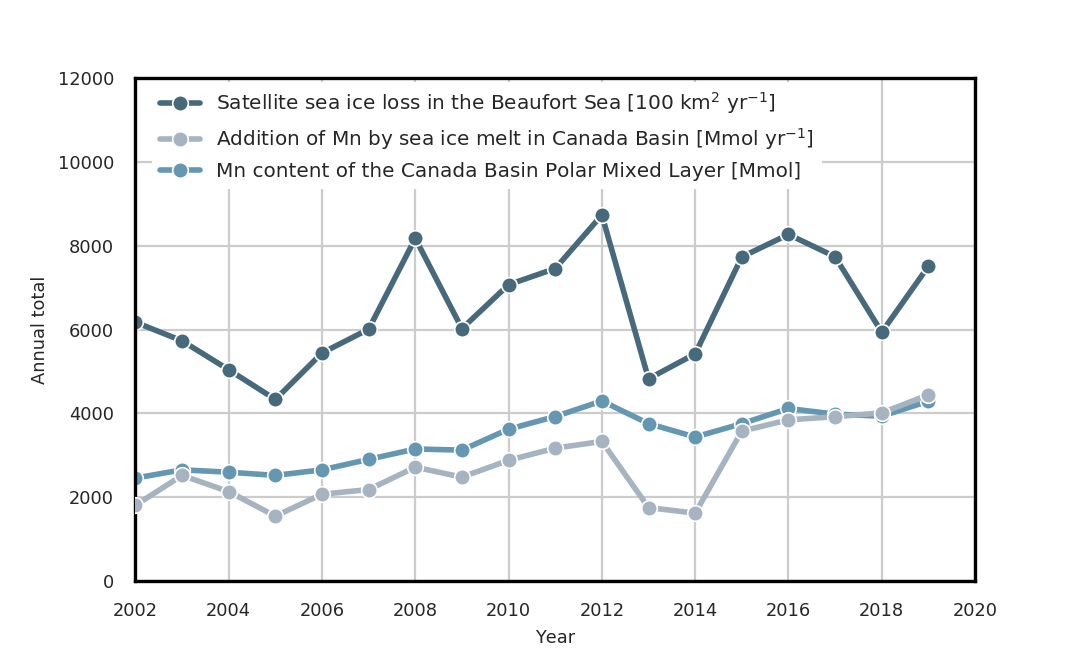

In [32]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(observ_years_CB, yearly_melt_CB*1e-2, linewidth=2.5, marker='o', markersize=7, color='#46697b',\
                       label=r'Satellite sea ice loss in the Beaufort Sea [100 km$^{2}$ yr$^{-1}$]', zorder=1)
    sns.lineplot(years, CB_totals_exp1[:,2]*1e-6, linewidth=2.5, color='#a6b3c0', marker="o", \
                 markersize=7, label=r'Addition of Mn by sea ice melt in Canada Basin [Mmol yr$^{-1}$]', zorder=3)
    sns.lineplot(years, CB_mn_timeseries*1e-6, linewidth=2.5, marker='o', markersize=7, color='#6497b1', \
                 label=r'Mn content of the Canada Basin Polar Mixed Layer [Mmol]', zorder=2)
#     ax = sns.lineplot(years, np.sum(totals_CB[:,:]*1e-6, axis=1), linewidth=2.5, color=colors[5], marker="o", \
#                        markersize=7, label=r'External Mn addition to Canada Basin [Mmol yr$^{-1}$]')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Annual total',fontsize=8)
    ax.set(xlim=(2002, 2020), ylim=(0, 1.2e4))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
#     ax.ticklabel_format(style='scientific', axis='y')
#     osi.ticklabel_format(style='scientific', axis='y')
    
    leg = ax.legend(loc=(0.02, 0.78), frameon=True, framealpha=1, fontsize=9)
    leg.get_frame().set_linewidth(0.0)
    
figure = plt.gcf()
figure.set_size_inches(4.5*1.5, 3.7*1.1)
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1/D1-interannual-time-series.png', \
                    bbox_inches='tight',dpi=300)
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1/D1-interannual-time-series.svg', \
                    bbox_inches='tight',dpi=300,format='svg')